
# NH data 2020: Estimating Air Changes Per Hour (ACH)

After a significant amount of CO2 is suddenly injected into a space (e.g. a cannister of CO2 is released for a short time, or a vinegar + baking soda reaction takes place), a CO2 sensor reading in the room will typically rise initially, then exponentially decay at a rate that is related to the effectiveness of ventilation in the room.  

Let's begin with our initial dataset, and plot the co2 value vs the time (in hours):

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import numpy as np
from scipy import stats

filename="co2data_2020.csv"
fd = pd.read_csv(filename)
fd

,deviceID,valCO2,date,time
0,444,798,2020-10-29,21:51:34.289013
1,444,798,2020-10-29,21:51:35.008680
2,444,798,2020-10-29,21:51:36.098750
3,444,798,2020-10-29,21:51:37.238304
4,444,798,2020-10-29,21:51:38.327734
...,...,...,...,...
1701,444,419,2020-10-29,22:22:55.343341
1702,444,419,2020-10-29,22:22:56.434139
1703,444,419,2020-10-29,22:22:57.525188
1704,444,419,2020-10-29,22:22:58.617172


In [9]:
fd['date_time']=fd['date']+' '+fd['time']
fd

,deviceID,valCO2,date,time,date_time
0,444,798,2020-10-29,21:51:34.289013,2020-10-29 21:51:34.289013
1,444,798,2020-10-29,21:51:35.008680,2020-10-29 21:51:35.008680
2,444,798,2020-10-29,21:51:36.098750,2020-10-29 21:51:36.098750
3,444,798,2020-10-29,21:51:37.238304,2020-10-29 21:51:37.238304
4,444,798,2020-10-29,21:51:38.327734,2020-10-29 21:51:38.327734
...,...,...,...,...,...
1701,444,419,2020-10-29,22:22:55.343341,2020-10-29 22:22:55.343341
1702,444,419,2020-10-29,22:22:56.434139,2020-10-29 22:22:56.434139
1703,444,419,2020-10-29,22:22:57.525188,2020-10-29 22:22:57.525188
1704,444,419,2020-10-29,22:22:58.617172,2020-10-29 22:22:58.617172


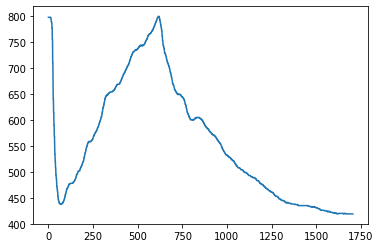

In [5]:

co2=feed_a_data['valCO2'].to_numpy()
plt.plot(co2)

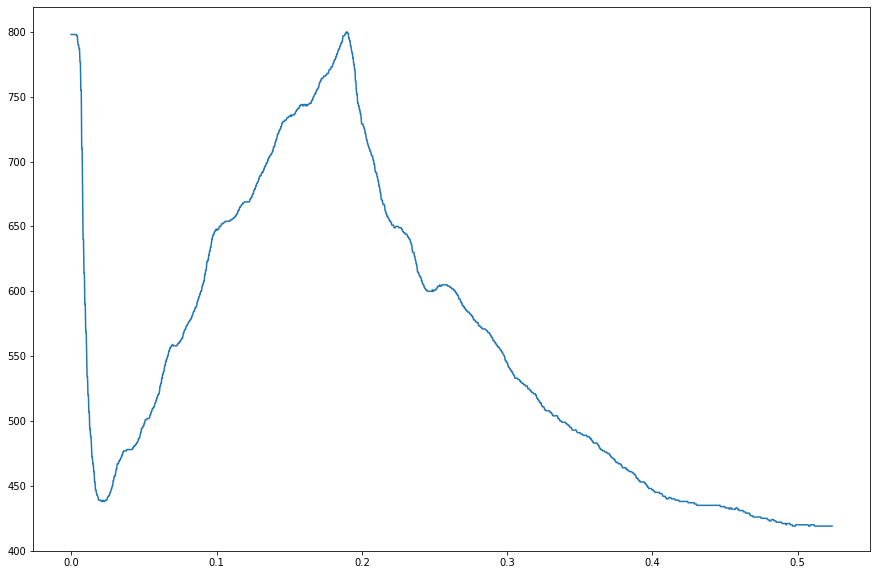

In [12]:

# get a time array in units of hours
t_hours=(pd.to_datetime(fd['date_time']).astype(int)/10**9)/3600
t_hours=(t_hours-t_hours[0]).to_numpy()

plt.figure(figsize=(15, 10))
plt.plot(t_hours,co2)

We'll now create a subset of this data, focusing on a particular exponential decay event.  We'll call the array of CO2 values for this subset $y$, and the array of time values for this subset $t$, and plot the resultant subset on top of the original dataset.

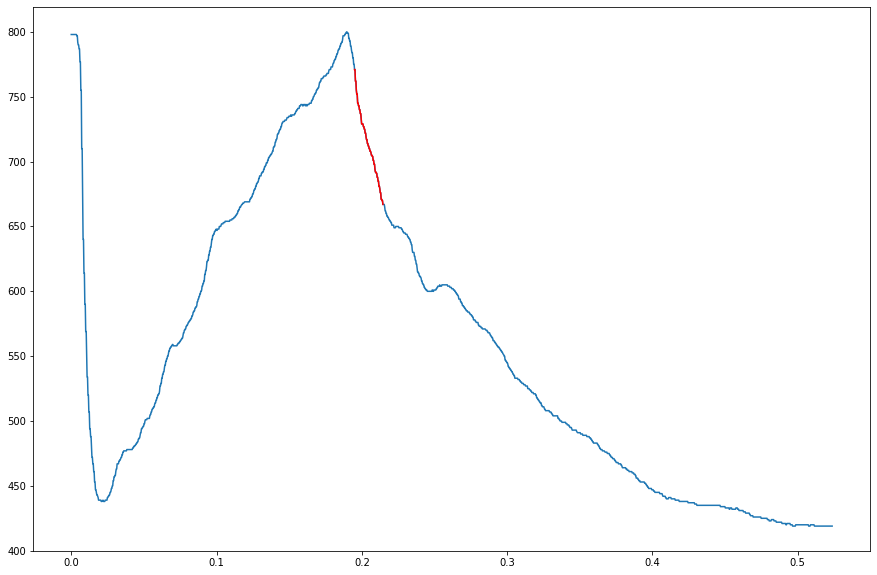

In [24]:
#index_min = 880
#index_max = 1250

index_min = 635
index_max = 700

y=co2[index_min:index_max]
t=t_hours[index_min:index_max]

plt.figure(figsize=(15, 10))
plt.plot(t_hours,co2)
plt.plot(t,y,'r')

The 'time constant' $\tau$ (measured in hours) for this exponential decay can -- under certain conditions [REF] -- be considered a rough estimate for the ['Air Changes Per Hour'](https://en.wikipedia.org/wiki/Air_changes_per_hour) in the room. That is, 

$ACH \approx \tau$

We can estimate $\tau$ (and thus the $ACH$ for the room) by:
1. Normalizing y values, so that they range between 0 and 1;
2. Normalizing the t values, so that they start at time = 0;
3. Linearizing the data by taking the natural log
4. Performing linear regression to extract the time constant $\tau$.

These steps are explained and illustrated below, assuming that (as in the above example), you have a subset of your CO2 data in which you assume an exponential decay has occured, where:
- $t$ = the time values of this subset of the data, in hours
- $y$ = the co2 values of this subset of the data, in PPM

## 1. Normalizing the CO2 values ($y$)

We can normalize the CO2 values ($y$) by first subtracting off the value to which the CO2 is expected to decay -- typically, the ambient CO2 (approx 420 ppm), $y_{ambient}$ -- and dividing by the maximum $y$ value (i.e., the first $y$ value in the decay, $y_0$:

$y_{norm} = \frac{y - y_{ambient}}{y_0 - y_{amplitude}}$



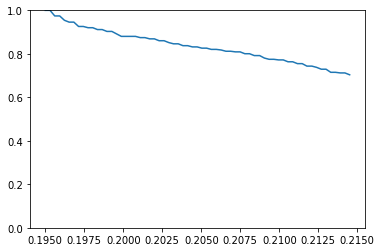

In [25]:
y_ambient=420
y_norm = (y-y_ambient)/(y[0]-y_ambient)

axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(t,y_norm)
plt.show()

## Normalizing the time values, $t$

Assuming the time values are in hours, we consider the first data point of our subset to be $t=0$; we therefore need to subtract off our time at $t=0$ from our $t$ values:

$t_{norm} = t-t_{0}$


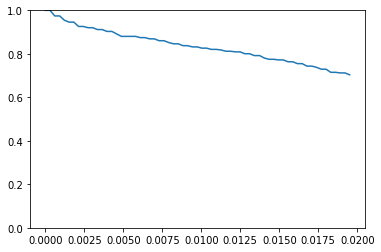

In [26]:
t_norm=t-t[0]

axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(t_norm,y_norm)
plt.show()


## Finding the time constant, $\tau$

With the data normalized in this way, the equation for the decay becomes:

$y_{norm}=e^{-t_{norm}/\tau}$

Where $\tau$ is the time constant of the decay (the value we seek).  

Taking the natural log of both sides, we get:

$\ln(y_{norm}) = \frac{-t_{norm}}{\tau}$

Note that this equation then has the form of a straight line,

$z=m*x$

where the slope $m$ is the negative inverse of $\tau$, i.e.:

$\tau = -m^{-1}$

We can then perform a linear fit of $\ln(y_{norm})$ vs. $\frac{-t_{norm}}{\tau}$ to find $\tau$.

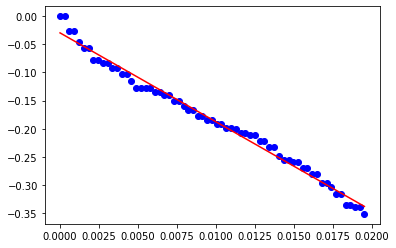

tau (ACH) = 0.06


In [27]:
# some plotting housekeeping
fig=plt.figure()
ax=fig.add_subplot(111)

# take the natural log of the normalize y data
log_y_norm = np.log(y_norm)

# perform a linear regress on the dataset: log_y_norm vs t_norm
slope, intercept, r_value, p_value, std_err = stats.linregress(t_norm,log_y_norm)

# plot log_y_norm vs t_norm, along with our linear fit
plt.plot(t_norm,log_y_norm,'bo',label="Data")
plt.plot(t_norm,slope*t_norm+intercept, 'r-',label="Polyfit")

plt.show()

tau = round(-1/slope,2)

print("tau (ACH) =",tau)